# Instructions

### This is a short tutorial on how to run the SSGPR code properly. We will run algorithm on 2 benchmarking data sets which is sufficient to highlight all the functionalities of the algorithm.


We shall begin by importing the ssgpr code, test functions, matplotlib for plotting, and numpy:

In [130]:
%matplotlib inline
import ssgpr
from test_functions import sinc,step
import matplotlib.pyplot as plt
import numpy as np

# <font color=green> The sinc test data set </font> 

Let's start by using a data set generated from the sinc test function. We will use 100 data points corrupted by spherical noise with a variance of 0.01:

In [131]:
x_train,y_train = sinc(100,noise=0.01)

We may visualize the data as a scatter plot:

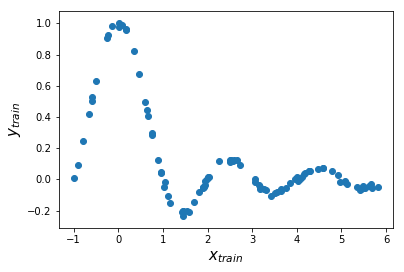

In [132]:
plt.scatter(x_train,y_train)
plt.xlabel('$x_{train}$',fontsize=15)
plt.ylabel('$y_{train}$',fontsize=15)
plt.show()

Now we shall instantiate an SSGPR model. the SSGPR instantiation takes 3 arguments: x_train, y_train, and the number of basis functions to use. We will be using 20 basis functions which is a relatively small amount to use:

## <font color=blue> Training the model </font>

In [133]:
sinc_model = ssgpr.SSGPR(x_train,y_train,20)

we can immediately visualize the instantiated model with the plot module:

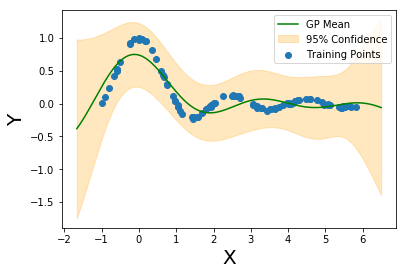

In [134]:
sinc_model.plot()

The SSGPR model contains 4 diffefent sets of hyperparameters. Firstly, there is the amplitude $\sigma_{f}$ which is the amplitude of the Random Fourier Feature (RFF) mapping. Secondly, there is $\sigma_n$  which is noise variance. Thirdly, the lengthscales $l_d$ for each input dimension, and finally the spectral frequencies $w_{md}$ (where $1<=m<=$number of basis function and $1<=d<=$input dimensions). 

Let $D$ be the dimensionality of the input data, and $M$ be the number of basis functions to use, the total number of hyperparameters is then $MD+D+2$.

When we instantiate the model, $\sigma_{f}$ , $\sigma_{n}$ and $l_d$ are all intialized to 1 and $w_{md}$ is smapled from a normal distribution of unit variance. Each parameter can be called upon as follows:

$\sigma_{n}$ :

In [135]:
sinc_model.noise

1.0

Note that the remaining three categories of hyperparameters pertain to the RFF mapping. The code has its own RFF object that is intantiated when the SSGPR object is intantiated, and all hyperparameters are kept in the RFF object.

$\sigma_f$ :

In [136]:
sinc_model.rff.sigma

1.0

$l_d$ : 

In [137]:
sinc_model.rff.l

array([ 1.])

$w_{md}$ : 

In [138]:
sinc_model.rff.w

array([[ 0.52714202],
       [-1.87656884],
       [ 1.15043846],
       [-1.83600556],
       [ 0.82628894],
       [ 1.43612684],
       [ 0.42427799],
       [ 0.84775568],
       [-1.16711619],
       [-1.46295941],
       [-0.94275701],
       [-0.50878807],
       [-1.23944667],
       [-0.00427558],
       [ 1.26522666],
       [ 1.47487594],
       [ 1.57495057],
       [-0.36609595],
       [ 1.92435708],
       [-0.88586676]])

If you wish you may prescribe your own values for any of these hyperparameters, just make sure that the following data types are obeyed. $\sigma_{f}$  $\sigma_{n}$ should be floats, $l_d$ should be a numpy array of floats, $w_{md}$ should be a <b><font color=red>flattened</font></b> array of floats. Don't forget that the sizes of both $l_d$ and $w_{md}$ must be compatible with the data at hand. Here is an example of changing all the hyperparameters:

In [139]:
sinc_model.noise = 2.0
sinc_model.rff.update_amplitude(2.0)
sinc_model.rff.update_lengthscales(np.array([2.0]))
sinc_model.rff.update_frequencies(np.random.normal(size=20))

We can check how the model has changed due to the reparametrization:

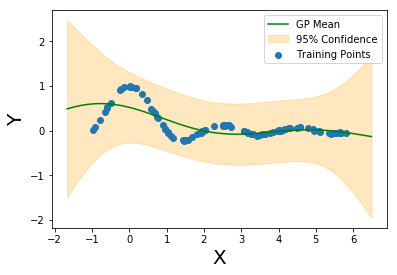

In [140]:
sinc_model.plot()

We can see that both of the models so far are not quite suitable. We need to optimize the hyperparameters. This is done by minimizing the negative log likelihood of the data with respect to the hyperparameters. The optimization module is optimize(restarts=1,method='CG',iterations=1000,verbose=True). Restarts is the number of times the optimization is restarted with randomized initializations (recomended to use more restarts as the complexity of the data increases). The method is the type of optimization algorithms to use. Optimization is done using the scipy.optimize.minimize module, hence you may specify any method they offer over there (https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.optimize.minimize.html) but I recommend sticking with CG or BFGS. Iterations is the maximum amount of iterations you wish each optimization to undergo and verbose is a boolean (True means you wish the optimization to print the progress, False will print out nothing).

We will now optimimize our model with 3 restarts with 100 iterations using a CG algorithm:

In [141]:
sinc_model.optimize(restarts=3,iterations=100,method='CG',verbose=True)

***************************************************
*              Optimizing parameters              *
***************************************************
restart # 1, negative log-likelihood = -249.117500
restart # 2, negative log-likelihood = -269.125483
restart # 3, negative log-likelihood = -264.701170


We may finally visualize our optimized model:

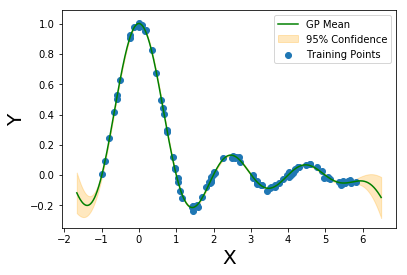

In [142]:
sinc_model.plot()

##  <font color=blue> Making predictions </font> 

We now have our trained model. We wish to perform inference (AKA predict) on a test set. the test set must be formatted just like the training set (2D array where each row is a test data point). For our case we will linearly sample 15 points.

In [143]:
x_test = np.linspace(-3,8,15).reshape(-1,1)  # note the reshape here to make the array 2D !!!

The predict module simply takes the 2D test data array and returns the tuple (mean,var) where mean is an array of mean values and var is and array of the point by point variance. 

In [144]:
mean,var = sinc_model.predict(x_test)

now we will compute the exact test function values and have a scatter plot with error bars corresponding to 2 standard deviations:

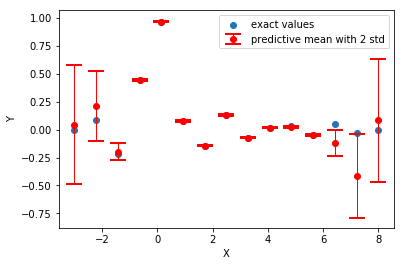

In [145]:
y_test = np.sinc(x_test).flatten()                 # exact function values
y_err  = 2*var 
plt.scatter(x_test.flatten(),y_test,label='exact values')
plt.errorbar(x_test,mean,yerr=y_err,color='r',fmt='o',capsize=8,capthick=2,elinewidth=1,label='predictive mean with 2 std')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


And that is essentially all the knowledge needed to run the code! Simple enough isn't it?




# <font color=green> Now we shall test on the step function </font>

We will used 100 training points corrupted by spherical noise with a variance of 0.01. We may then visualize the data with a scatter plot.

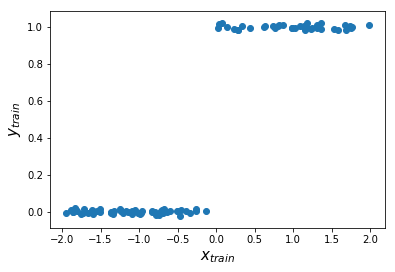

In [155]:
x_train,y_train = step(100,noise=0.01)
plt.scatter(x_train,y_train)
plt.xlabel('$x_{train}$',fontsize=15)
plt.ylabel('$y_{train}$',fontsize=15)
plt.show()

We will use 50 basis functions for this problem since it's a more difficult function to approximate than that of sinc. Generally speaking, adding basis functions gives our model more flexibility... but also we may start to overfit due to the heavy parametrization. So be aware!

In [156]:
step_model = ssgpr.SSGPR(x_train,y_train,50)

Let's check out our suboptimal model:

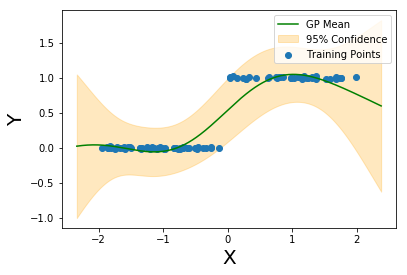

In [157]:
step_model.plot()

This is clearly not good enough. Let's optimize the hyperparamters:

In [158]:
step_model.optimize(restarts=3,iterations=200,method='CG')

***************************************************
*              Optimizing parameters              *
***************************************************
restart # 1, negative log-likelihood = -151.461062
restart # 2, negative log-likelihood = -151.057190
restart # 3, negative log-likelihood = -193.608107


And for the optimized model:

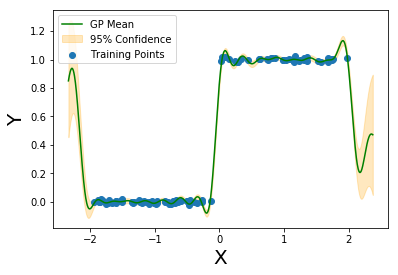

In [159]:
step_model.plot()

We can now make predictions. we will once more sample our training points linearly, get the predicted mean and variance, and plot the error bars along with the true values. 

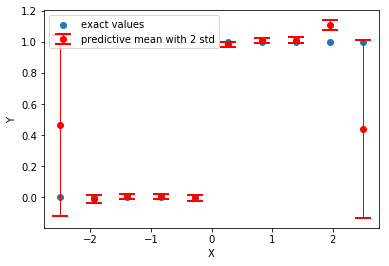

In [160]:
x_test   = np.linspace(-2.5,2.5,10).reshape(-1,1)
mean,var = step_model.predict(x_test) 
y_test = np.greater(x_test,0).flatten()                 # exact function values
y_err  = 2*var 
plt.scatter(x_test.flatten(),y_test,label='exact values')
plt.errorbar(x_test,mean,yerr=y_err,color='r',fmt='o',capsize=8,capthick=2,elinewidth=1,label='predictive mean with 2 std')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()